In [384]:
import torch
from torch import (optim, nn)

from torch.utils.data import (
    DataLoader,
    TensorDataset,
    random_split
)

import numpy as np

# User-defined classes
from utils.base import (
    # LinearRegression,
    LogisticRegression,
    Trainer
)

# Plotting
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = "monospace"

In [385]:
# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32
BATCH_SIZE = 32
NUM_EPOCHS = 50
SIZE = 80
GENERATOR = torch.Generator().manual_seed(42)

print(f"Device has ben set to: {torch.cuda.get_device_properties(DEVICE).name}")

Device has ben set to: NVIDIA GeForce RTX 4060 Laptop GPU


In [386]:
T = torch.randn(SIZE, 1, dtype=DTYPE, generator=GENERATOR, device='cpu')

X0 = .8 * T + 3 + torch.randn(SIZE, 1, dtype=DTYPE, generator=GENERATOR, device='cpu')
X1 = T - .3 + torch.randn(SIZE, 1, dtype=DTYPE, generator=GENERATOR, device='cpu')

X = torch.tensor(np.concatenate([X0, X1], dtype=np.float32, axis=1))

W = torch.randn(2, dtype=DTYPE, device='cpu')
b = torch.randn(1, dtype=DTYPE, device='cpu')

y = X @ W + b

In [387]:
print("Generated X:", X, "\nGenerated y:", y, sep='\n')

Generated X:
tensor([[ 4.5524, -0.2736],
        [ 3.8511,  1.4159],
        [ 2.3799,  0.6256],
        [ 0.7302, -2.7515],
        [ 4.0789,  0.6653],
        [ 2.5370, -2.2654],
        [ 4.1067, -0.1682],
        [ 1.7679, -2.9986],
        [ 3.1422, -2.6543],
        [ 3.8374,  2.7016],
        [ 1.6366,  0.5963],
        [ 2.4810, -1.6513],
        [ 0.6954, -2.5747],
        [ 1.7247, -0.1027],
        [ 3.7196, -0.2933],
        [ 4.0935,  2.4890],
        [ 1.8043,  1.3781],
        [ 3.3603, -0.3390],
        [ 3.3867, -1.6031],
        [ 3.3803, -0.0680],
        [ 3.0343, -1.9901],
        [ 4.4459, -0.8126],
        [ 4.7076, -0.6352],
        [ 3.8943,  0.8580],
        [ 3.8380,  0.4604],
        [ 4.7899, -0.5049],
        [ 3.8931, -1.6162],
        [ 4.2463,  1.1626],
        [ 3.0796,  0.4913],
        [ 4.3066, -0.8140],
        [ 2.7974,  0.1527],
        [ 3.3843,  1.2697],
        [ 0.4352,  0.0897],
        [ 2.2007, -2.0928],
        [ 2.2222,  0.4391],
       

In [388]:
print("Generated Parameters:", "Weights: {}".format(W), "Bias: {}".format(b), sep='\n')

Generated Parameters:
Weights: tensor([-0.1219, -0.4075])
Bias: tensor([-0.8193])


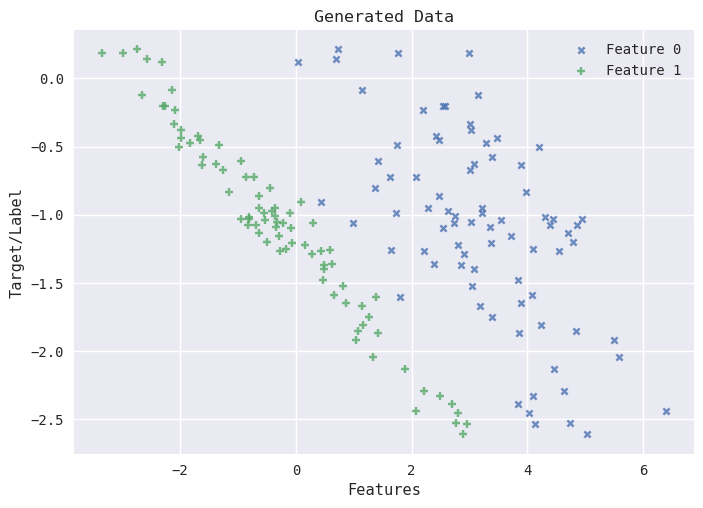

In [389]:
plt.scatter(X[:, 0].numpy(), y.numpy(), label="Feature 0", marker='x', alpha=.8, s=20);
plt.scatter(X[:, 1].numpy(), y.numpy(), label="Feature 1", marker='+', alpha=.8, s=40);
plt.xlabel("Features");
plt.ylabel("Target/Label");
plt.title("Generated Data");
plt.legend(loc='best');
plt.show();

In [7]:
# Transforming y to get logits
probs = torch.sigmoid(y)
print("Probs:", probs, sep='\n')

Probs:
tensor([0.1723, 0.9024, 0.7731, 0.8196, 0.1002, 0.7744, 0.5611, 0.2279, 0.5500,
        0.3061, 0.1727, 0.1223, 0.1874, 0.1650, 0.4170, 0.2242, 0.6178, 0.1013,
        0.5675, 0.6583, 0.1667, 0.5662, 0.0570, 0.5205, 0.5802, 0.3063, 0.1616,
        0.6049, 0.3718, 0.2677, 0.0909, 0.1218, 0.2781, 0.3877, 0.5064, 0.1374,
        0.2980, 0.3293, 0.6351, 0.5523, 0.5313, 0.5429, 0.3231, 0.4709, 0.6001,
        0.2512, 0.5928, 0.3634, 0.2300, 0.4624, 0.3129, 0.6047, 0.2475, 0.4063,
        0.1664, 0.5212, 0.4060, 0.2938, 0.4429, 0.2895, 0.3733, 0.2551, 0.3912,
        0.3580, 0.2603, 0.6807, 0.1113, 0.3151, 0.4800, 0.1718, 0.1895, 0.2558,
        0.1869, 0.1707, 0.5068, 0.3804, 0.2210, 0.1092, 0.4492, 0.2065, 0.3058,
        0.5339, 0.6467, 0.7284, 0.1181, 0.4769, 0.2069, 0.0865, 0.4068, 0.4612,
        0.7941, 0.5341, 0.7892, 0.3289, 0.6305, 0.2858, 0.7434, 0.5702, 0.3012,
        0.1592, 0.0763, 0.6663, 0.1980, 0.3684, 0.6772, 0.5795, 0.3294, 0.9075,
        0.1811, 0.0987, 0.5875, 0

In [8]:
y = (y > .5).type(DTYPE)
print("New values for y:", y, sep='\n')

New values for y:
tensor([0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0.

In [9]:
print("# of instances at each class (for 0 and 1)")
print("0: {}".format(y[y == 0].numel()), "1: {}".format(y[y == 1].numel()), sep='\n')

# of instances at each class (for 0 and 1)
0: 234
1: 66


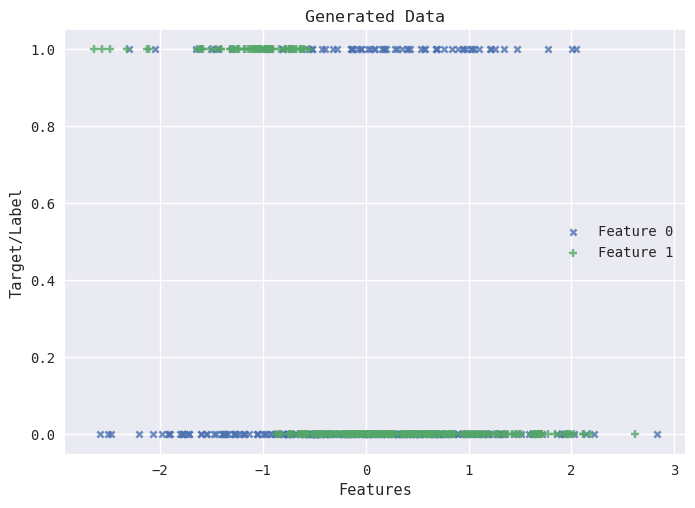

In [10]:
plt.scatter(X[:, 0].numpy(), y.numpy(), label="Feature 0", marker='x', alpha=.8, s=20);
plt.scatter(X[:, 1].numpy(), y.numpy(), label="Feature 1", marker='+', alpha=.8, s=40);
plt.xlabel("Features");
plt.ylabel("Target/Label");
plt.title("Generated Data");
plt.legend(loc='best');
plt.show();

In [363]:
Model = LogisticRegression(in_dims=2).to(DEVICE)

In [364]:
Data = TensorDataset(X, y)
Data.tensors

(tensor([[ 1.9269e+00,  1.4873e+00],
         [ 9.0072e-01, -2.1055e+00],
         [ 6.7842e-01, -1.2345e+00],
         [-4.3067e-02, -1.6047e+00],
         [-7.5214e-01,  1.6487e+00],
         [-3.9248e-01, -1.4036e+00],
         [-7.2788e-01, -5.5943e-01],
         [-7.6884e-01,  7.6245e-01],
         [ 1.6423e+00, -1.5960e-01],
         [-4.9740e-01,  4.3959e-01],
         [-7.5813e-01,  1.0783e+00],
         [ 8.0080e-01,  1.6806e+00],
         [ 1.2791e+00,  1.2964e+00],
         [ 6.1047e-01,  1.3347e+00],
         [-2.3162e-01,  4.1759e-02],
         [-2.5158e-01,  8.5986e-01],
         [-1.3847e+00, -8.7124e-01],
         [-2.2337e-01,  1.7174e+00],
         [ 3.1888e-01, -4.2452e-01],
         [ 3.0572e-01, -7.7459e-01],
         [-1.5576e+00,  9.9564e-01],
         [-8.7979e-01, -6.0114e-01],
         [-1.2742e+00,  2.1228e+00],
         [-1.2347e+00, -4.8791e-01],
         [-9.1382e-01, -6.5814e-01],
         [ 7.8024e-02,  5.2581e-01],
         [-4.8799e-01,  1.1914e+00],
 

In [365]:
trainData, valData = random_split(Data, (0.8, 0.2), generator=GENERATOR)

trainLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)
valLoader = DataLoader(valData, batch_size=BATCH_SIZE, shuffle=True)

In [366]:
trainer = Trainer(
    Model,
    trainLoader,
    valLoader,
    optimizer=optim.SGD(Model.parameters(), lr=.1),
    criterion=nn.CrossEntropyLoss(reduction='mean'),        # Cross-entropy Loss (For classification)
    device=DEVICE
)

In [367]:
train_loss, val_loss = trainer.train(num_epochs=NUM_EPOCHS)

	Epoch 1 | Weights: tensor([0.0159, 0.1758], device='cuda:0')
	Epoch 1 | Bias: tensor([1.4648], device='cuda:0')
	Epoch 1 | Weights: tensor([0.1203, 0.0064], device='cuda:0')
	Epoch 1 | Bias: tensor([1.4824], device='cuda:0')
	Epoch 1 | Weights: tensor([ 0.2747, -0.0942], device='cuda:0')
	Epoch 1 | Bias: tensor([1.4721], device='cuda:0')
	Epoch 1 | Weights: tensor([ 0.3449, -0.2199], device='cuda:0')
	Epoch 1 | Bias: tensor([1.4516], device='cuda:0')
	Epoch 1 | Weights: tensor([ 0.4284, -0.3839], device='cuda:0')
	Epoch 1 | Bias: tensor([1.4134], device='cuda:0')
	Epoch 1 | Weights: tensor([ 0.4898, -0.5700], device='cuda:0')
	Epoch 1 | Bias: tensor([1.3648], device='cuda:0')
	Epoch 1 | Weights: tensor([ 0.6127, -0.6866], device='cuda:0')
	Epoch 1 | Bias: tensor([1.2996], device='cuda:0')
	Epoch 1 | Weights: tensor([ 0.7004, -0.7563], device='cuda:0')
	Epoch 1 | Bias: tensor([1.2597], device='cuda:0')
Epoch 1/50 | Loss: 48.3202
	| Validation Loss: 59.6892

	Epoch 2 | Weights: tensor([

In [ ]:
print("Train Loss:", train_loss, "\nValidation Loss:", val_loss, sep='\n')

Train Loss:
{0: 48.320212841033936, 1: 46.10823655128479, 2: 45.26330232620239, 3: 45.05759572982788, 4: 44.711483001708984, 5: 44.783533573150635, 6: 44.357308864593506, 7: 44.63487350940704, 8: 44.336910247802734, 9: 44.313270568847656, 10: 44.342719078063965, 11: 44.329293727874756, 12: 44.04094386100769, 13: 44.479573369026184, 14: 44.148831844329834, 15: 44.200077295303345, 16: 44.05049228668213, 17: 44.07519173622131, 18: 44.0997679233551, 19: 44.160826206207275, 20: 44.06341886520386, 21: 44.25905358791351, 22: 43.98262071609497, 23: 44.141093492507935, 24: 44.05952286720276, 25: 44.07665157318115, 26: 44.21012830734253, 27: 44.34569025039673, 28: 44.27888226509094, 29: 44.056602239608765, 30: 43.77375602722168, 31: 44.33574390411377, 32: 44.22958600521088, 33: 43.96290063858032, 34: 43.90819025039673, 35: 43.91412878036499, 36: 44.08531403541565, 37: 44.008246421813965, 38: 43.85291337966919, 39: 43.929402351379395, 40: 43.80627250671387, 41: 43.90605449676514, 42: 44.250884175

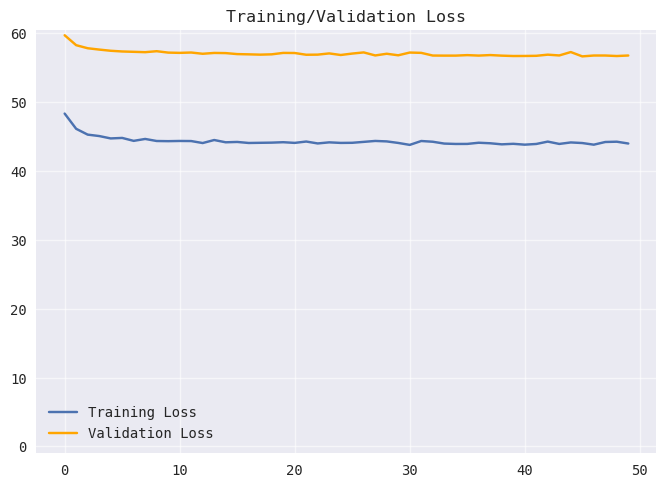

In [368]:
plt.plot(
    train_loss.keys(),
    train_loss.values(),
    label="Training Loss"
);
plt.plot(
    val_loss.keys(),
    val_loss.values(),
    color="orange",
    label="Validation Loss"
);
plt.ylim(bottom=-1)
plt.grid(True, alpha = .6);
plt.title("Training/Validation Loss");
plt.legend(loc='best');
plt.show()